# Spam Email Detection Using Average Word2Vec 

In [1]:
import numpy as np
import pandas as pd
import os


### Load the Data

In [3]:
# Read in data
df = pd.read_csv('./dataset/Phishing_Email.csv')
print(df.shape)

df.head()

(18650, 3)


,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


### Exploring columns in the dataframe

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


### Checking Whether the Data contains any Null Values

In [5]:
df.isna().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

### Composition of Phising and Safe mails in the Data using simple CountPlot of Seaborn

<AxesSubplot:xlabel='Email Type', ylabel='count'>

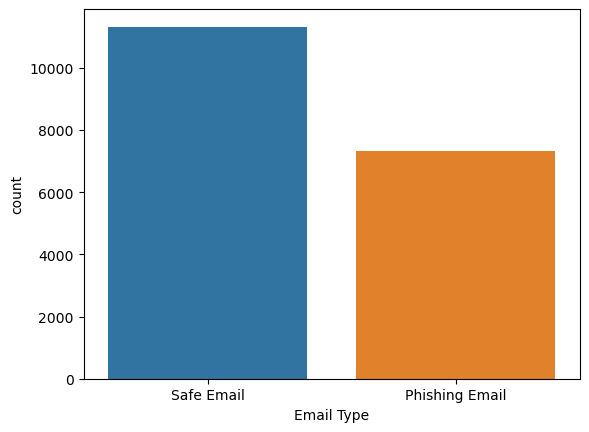

In [6]:
import seaborn as sns
sns.countplot(x="Email Type",data=df)

In [8]:
print(df['Email Text'][0])

re : 6 . 1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hudson 's observations on us use of 's on ' but not 'd aughter ' as a vocative are very thought-provoking , but i am not sure that it is fair to attribute this to " sons " being " treated like senior relatives " . for one thing , we do n't normally use ' brother ' in this way any more than we do 'd aughter ' , and it is hard to imagine a natural class comprising senior relatives and 's on ' but excluding ' brother ' . for another , there seem to me to be differences here . if i am not imagining a distinction that is not there , it seems to me that the senior relative terms are used in a wider variety of contexts , e . g . , calling out from a distance to get someone 's attention , and hence at the beginning of an utterance , whereas 's on ' seems more natural in utterances like ' yes , son ' , ' hand me that , son ' than in ones like ' son ! ' or ' son , help me ! ' ( although perhaps these latter ones are not compl

In [9]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.6 MB/s eta 0:00:00


In [10]:
import contractions
from tqdm import tqdm
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords=stopwords.words('english')
stopwords.remove('no')
stopwords.remove('nor')
stopwords.remove('not')

[nltk_data] Downloading package stopwords to /home/anshu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
processed_mails=[]
for i in tqdm(df['Email Text']):
    processed_mails.append(" ".join([j.lower() for j in i.split() if j not in stopwords and len(j)>=3]))

### Creating a Dataframe using all the cleaned Mails

In [ ]:
#Creating a new datafram using the Processed Reviews
processed_df=pd.DataFrame({'text':processed_mails,'Phish/Safe':list(df['Email Type'])})
processed_df.head()

## <center> Data Preparation </center>

In [11]:
#Splitting the data into dependent and independent variables i.e, features and the target columns
X=processed_df['text']
Y=processed_df['Spam/Ham']
#Splitting the data such that 33% will be used for testing and the remaining 67% will be used for training. 
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,stratify=Y,test_size=0.33)
#when stratify is provided the splitting of data into train and test datasets agree with the composition of actual possitive and negative reviews present in the dataset

In [12]:
from gensim.models import Word2Vec

## Creating the data for training the Word2Vec model

In [13]:
words_in_sentences=[]
for i in tqdm(x_train):
    words_in_sentences.append(i.split())

100%|██████████| 3464/3464 [00:00<00:00, 94418.79it/s]


### Training a Word2Vec Model with our Custom data

In [14]:
model = Word2Vec(sentences=words_in_sentences, vector_size=200,workers=-1)

## Total number of words in the Vocabulary on which the Word2Vec model is trained.

In [17]:
vocab=list(model.wv.key_to_index.keys())
print(len(vocab))

6649


### **Average Word2Vec , average of word embeddings of all the words given in a sentence is used as the numerical vector for a given sentence.**

In [18]:
def avg_w2vec(sentences):
    transformed=[]
    for sentence in tqdm(sentences):
        count=0
        vector=np.zeros(200)
        for word in sentence.split():
            if word in vocab:
                vector+=model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
        else:
            print(sentence)
    return np.array(transformed)

In [19]:
x_train_transformed=avg_w2vec(x_train)
x_test_transformed=avg_w2vec(x_test)

100%|██████████| 1707/1707 [00:05<00:00, 318.37it/s]


## Using K-Nearest Neighbors Algorithm for classification

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
grid_params = { 'n_neighbors' : [10,20,30,40,50,60],
               'metric' : ['manhattan']}
knn=KNeighborsClassifier()
clf = RandomizedSearchCV(knn, grid_params, random_state=0,n_jobs=-1,verbose=1)
clf.fit(x_train_transformed,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.7s finished


RandomizedSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'metric': ['manhattan'],
                                        'n_neighbors': [10, 20, 30, 40, 50,
                                                        60]},
                   random_state=0, verbose=1)

In [21]:
clf.best_params_

{'n_neighbors': 10, 'metric': 'manhattan'}

In [22]:
clf.best_score_

0.7982066745072525

In [23]:
clf.cv_results_

{'mean_fit_time': array([0.07366505, 0.07172437, 0.0677135 , 0.06882086, 0.0704308 ,
        0.06964426]),
 'std_fit_time': array([0.0036415 , 0.0049972 , 0.00091277, 0.00101656, 0.00287808,
        0.00145807]),
 'mean_score_time': array([1.22993546, 1.41144609, 1.24042358, 1.23959513, 1.2854876 ,
        1.13555822]),
 'std_score_time': array([0.08687633, 0.12765505, 0.00435392, 0.00441002, 0.02044739,
        0.19104584]),
 'param_n_neighbors': masked_array(data=[10, 20, 30, 40, 50, 60],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_metric': masked_array(data=['manhattan', 'manhattan', 'manhattan', 'manhattan',
                    'manhattan', 'manhattan'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 10, 'metric': 'manhattan'},
  {'n_neighbors': 20, 'metric': 'manhattan'},
  {'n_neighbors': 30, 'metric': 'manh

# <center><b> Model Evaluation </b></center>

## Plotting the ROC curve for the prediction on both Training and Testing Data

In [24]:
from sklearn.metrics import roc_curve, auc,classification_report,confusion_matrix
train_fpr,train_tpr,thresholds=roc_curve(y_train,clf.predict_proba(x_train_transformed)[:,1])
test_fpr,test_tpr,thresholds=roc_curve(y_test,clf.predict_proba(x_test_transformed)[:,1])

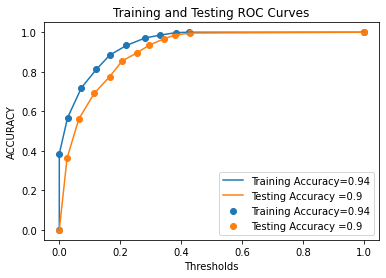

In [25]:
import matplotlib.pyplot as plt
plt.plot(train_fpr,train_tpr,label="Training Accuracy="+str(round(auc(train_fpr, train_tpr),2)))
plt.plot(test_fpr,test_tpr,label="Testing Accuracy ="+str(round(auc(test_fpr, test_tpr),2)))
plt.scatter(train_fpr,train_tpr,label="Training Accuracy="+str(round(auc(train_fpr, train_tpr),2)))
plt.scatter(test_fpr,test_tpr,label="Testing Accuracy ="+str(round(auc(test_fpr, test_tpr),2)))
plt.legend()
plt.xlabel("Thresholds")
plt.ylabel("ACCURACY")
plt.title("Training and Testing ROC Curves")
plt.show()

## Confusion Matrix and Classification Report for Prediction made on Training and Testing data

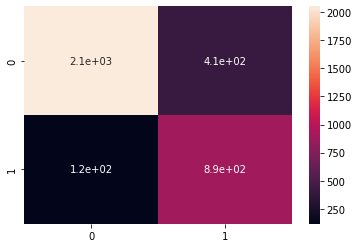

In [26]:
sns.heatmap(confusion_matrix(y_train,clf.predict(x_train_transformed)),annot=True)
plt.show()

In [27]:
print(classification_report(y_train,clf.predict(x_train_transformed)))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      2460
           1       0.69      0.88      0.77      1004

    accuracy                           0.85      3464
   macro avg       0.82      0.86      0.83      3464
weighted avg       0.87      0.85      0.85      3464



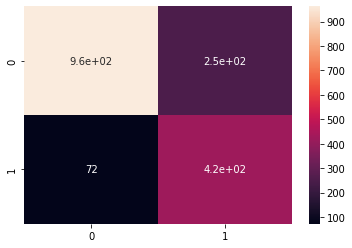

In [28]:
sns.heatmap(confusion_matrix(y_test,clf.predict(x_test_transformed)),annot=True)
plt.show()

In [29]:
print(classification_report(y_test,clf.predict(x_test_transformed)))

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      1212
           1       0.63      0.85      0.72       495

    accuracy                           0.81      1707
   macro avg       0.78      0.82      0.79      1707
weighted avg       0.84      0.81      0.82      1707

